In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt

from datetime import datetime
from scipy.interpolate import interp1d
from scipy.optimize import least_squares

## Load Data and Plot implied Vol curves

In [2]:
#load spx and spy data
df_spx_raw = pd.read_csv("SPX_options.csv")
df_spy_raw = pd.read_csv("SPY_options.csv")

df_rates_raw = pd.read_csv("zero_rates_20201201.csv")

In [9]:
df_spx_raw

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style
0,20201201,20201218,C,100000,3547.6,3570.5,E
1,20201201,20201218,C,200000,3447.6,3470.5,E
2,20201201,20201218,C,300000,3347.7,3370.6,E
3,20201201,20201218,C,400000,3247.7,3270.6,E
4,20201201,20201218,C,500000,3147.7,3170.6,E
...,...,...,...,...,...,...,...
2067,20201201,20210219,P,5000000,1333.1,1350.5,E
2068,20201201,20210219,P,5100000,1431.8,1454.7,E
2069,20201201,20210219,P,5200000,1531.7,1554.6,E
2070,20201201,20210219,P,5300000,1631.5,1654.4,E


In [140]:
df_spx = df_spx_raw.copy()
df_spy = df_spy_raw.copy()
df_rates = df_rates_raw.copy()

In [141]:
#rates are in %
df_rates.head()

,date,days,rate
0,20201201,7,0.102280
1,20201201,13,0.114128
2,20201201,49,0.216480
3,20201201,77,0.220707
4,20201201,104,0.219996


In [142]:
#convert rate to unity
df_rates['rate'] = df_rates['rate']/100
#divide strike price by 1000
df_spx["strike_price"] = df_spx["strike_price"]/1000
df_spy["strike_price"] = df_spy["strike_price"]/1000

In [143]:
#example of interpolating rate for a given day eg. on day 17
rates_interp = interp1d(list(df_rates["days"]), list(df_rates["rate"]))
rates_interp([17])[0]

0.0012550044444444445

In [144]:
# underlying price of SPX and SPY on 20201201
spx_underlying = 3662.45
spy_underlying = 366.02

In [145]:
def BlackScholesCall(S, K, r, sigma, T):
    "return Black Scholes price for call option given sigma"
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesPut(S, K, r, sigma, T):
    "return Black Scholes price for put option given sigma"
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def impliedVolatility(S, K, r, price, T, payoff):
    "return implied volatility using black scholes given price"
    #try:
    if (payoff.lower() == 'c'):
        impliedVol = brentq(lambda x: price -
                            BlackScholesCall(S, K, r, x, T),
                            -1e-12, 10)
    elif (payoff.lower() == 'p'):
        impliedVol = brentq(lambda x: price -
                            BlackScholesPut(S, K, r, x, T),
                            -1e-12, 10)
    else:
        raise NameError('Payoff type not recognized')
    return impliedVol



In [146]:
def interpolate( c_strike, c_vol, p_strike, p_vol, underlying):
    "interpolate nearest otm call and otm put volatility to get ATM volatility"
    return (underlying - p_strike) / (c_strike - p_strike) * (c_vol - p_vol) + p_vol

In [10]:
#if strike above underlying, and cp_flag is call, then OTM
#if strike below underlying, and cp_flag is put, then OTM

df_spx["moneyness"] = "ITM" 

df_spx.loc[(df_spx["cp_flag"] == "C")  & (df_spx["strike_price"] > spx_underlying), "moneyness" ] = "OTM"
df_spx.loc[(df_spx["cp_flag"] == "P")  & (df_spx["strike_price"] < spx_underlying), "moneyness" ] = "OTM"

df_spy["moneyness"] = "ITM" 

df_spy.loc[(df_spy["cp_flag"] == "C")  & (df_spy["strike_price"] > spy_underlying), "moneyness" ] = "OTM"
df_spy.loc[(df_spy["cp_flag"] == "P")  & (df_spy["strike_price"] < spy_underlying), "moneyness" ] = "OTM"

In [11]:
#using average of best bid and best offer to get mid price, which will be used to calculate implied volatility

df_spx["mid_price"] = (df_spx["best_bid"] + df_spx["best_offer"])/2
df_spy["mid_price"] = (df_spy["best_bid"] + df_spy["best_offer"])/2

In [12]:
#change expiry to datetime format
df_spx["expiry"] = pd.to_datetime(df_spx["exdate"], format = "%Y%m%d")
df_spy["expiry"] = pd.to_datetime(df_spy["exdate"], format = "%Y%m%d")

In [13]:
#calculate days from expiry for each SPX and SPY options

df_spx["days"] = df_spx["expiry"] -  datetime(2020,12,1)
df_spx["days"] = df_spx["days"].dt.days 
df_spx["T"] = df_spx["days"] / 365

df_spy["days"] = df_spy["expiry"] -  datetime(2020,12,1)
df_spy["days"] = df_spy["days"].dt.days 
df_spy["T"] = df_spy["days"] / 365

In [14]:
#calculate rates by interpolating using "zero rates 20201201.csv"

df_spx["r"] = df_spx["days"].apply(lambda x: rates_interp([x])[0])
df_spy["r"] = df_spy["days"].apply(lambda x: rates_interp([x])[0])

In [15]:
#calculate forward price at expiry F(T)
df_spx["F"] = spx_underlying * np.power(np.e, ((df_spx["r"]) * (df_spx["T"])))
df_spy["F"] = spy_underlying * np.power(np.e, ((df_spy["r"]) * (df_spy["T"])))

In [16]:
def calc_implied_vol(S,K, r, price, T, flag, moneyness):
    "calculate implied volality for OTM only"
    if moneyness != "OTM":
        return np.nan
    else:
        impliedvol = impliedVolatility(S, K, r, price, T, flag)
        #print(impliedvol)
        return impliedvol

In [17]:
#calculate implied vol for OTM only

df_spx["impliedvol"] = df_spx.apply(lambda r: calc_implied_vol(
                        spx_underlying,
                        r["strike_price"],
                        r["r"],
                        r["mid_price"],
                        r['T'],
                        r["cp_flag"],
                        r["moneyness"]
                        ), axis = 1)


df_spy["impliedvol"] = df_spy.apply(lambda r: calc_implied_vol(
                        spy_underlying,
                        r["strike_price"],
                        r["r"],
                        r["mid_price"],
                        r['T'],
                        r["cp_flag"],
                        r["moneyness"]
                        ), axis = 1)

In [19]:
#only interested in the OTM options to plot volatility smile

df_spx_otm = df_spx[df_spx["moneyness"] == "OTM"]
df_spy_otm = df_spy[df_spy["moneyness"] == "OTM"]

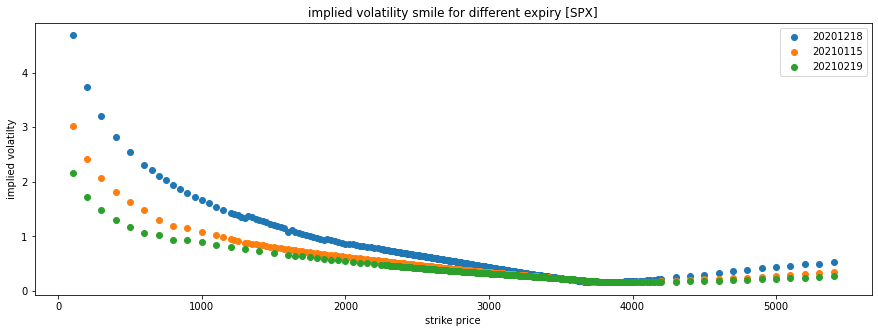

In [20]:
## plot implied vol for 3 exipry
exdate_gb = df_spx_otm.groupby("exdate")
plt.figure(figsize = (15,5))
for i, df in exdate_gb:
    plt.scatter(df["strike_price"],df["impliedvol"], label = i, )
plt.legend()
plt.title("implied volatility smile for different expiry [SPX]")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()



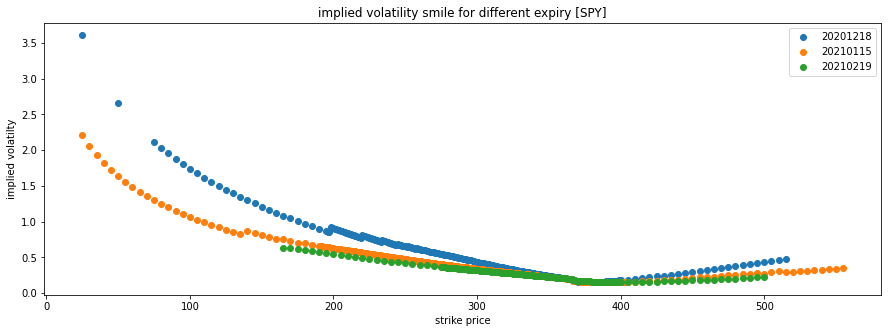

In [21]:
## plot implied vol for 3 exipry
exdate_gb = df_spy_otm.groupby("exdate")
plt.figure(figsize = (15,5))
for i, df in exdate_gb:
    plt.scatter(df["strike_price"],df["impliedvol"], label = i, )
plt.legend()
plt.title("implied volatility smile for different expiry [SPY]")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()

## calibrate SABR model (fix beta = 0.7)
plot the fitted implied volatility smile against the market data

In [23]:
beta = 0.7

def sabrcalibration(x, strikes, vols, F, T):
    beta = 0.7
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

#### SABR model for SPX

In [24]:
df_spx_dec = df_spx_otm[df_spx_otm["exdate"] == 20201218].reset_index(drop = True)
df_spx_jan = df_spx_otm[df_spx_otm["exdate"] == 20210115].reset_index(drop = True)
df_spx_feb = df_spx_otm[df_spx_otm["exdate"] == 20210219].reset_index(drop = True)

In [25]:
#Dec tuning
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df_spx_dec['strike_price'],
                                              df_spx_dec['impliedvol'],
                                              df_spx_dec["F"].iloc[0],
                                              df_spx_dec["T"].iloc[0]),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

tuned_params_dec_spx = (alpha, beta, rho, nu)

C:\Users\Statistician\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Statistician\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


In [26]:
print('Calibrated SABR model parameters for 20201218 expiry: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

Calibrated SABR model parameters for 20201218 expiry: alpha = 1.212, beta = 0.7, rho = -0.301, nu = 5.460


In [27]:
#Jan tuning
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df_spx_jan['strike_price'],
                                              df_spx_jan['impliedvol'],
                                              df_spx_jan["F"].iloc[0],
                                              df_spx_jan["T"].iloc[0]),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

tuned_params_jan_spx = (alpha, beta, rho, nu)

C:\Users\Statistician\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log
C:\Users\Statistician\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [28]:
print('Calibrated SABR model parameters for 20210115 expiry: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

Calibrated SABR model parameters for 20210115 expiry: alpha = 1.817, beta = 0.7, rho = -0.404, nu = 2.790


In [29]:
#Feb tuning
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df_spx_feb['strike_price'],
                                              df_spx_feb['impliedvol'],
                                              df_spx_feb["F"].iloc[0],
                                              df_spx_feb["T"].iloc[0]),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

tuned_params_feb_spx = (alpha, beta, rho, nu)

In [30]:
print('Calibrated SABR model parameters for 20210219 expiry: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

Calibrated SABR model parameters for 20210219 expiry: alpha = 2.140, beta = 0.7, rho = -0.575, nu = 1.842


In [31]:
#using calibrated SABR parameters to calculate implied vol at each strike for plotting purpose

strikes_dec_spx = np.arange(df_spx_dec["strike_price"].min(), df_spx_dec["strike_price"].max()+5 , 5)
strikes_jan_spx = np.arange(df_spx_jan["strike_price"].min(), df_spx_jan["strike_price"].max()+5 , 5)
strikes_feb_spx = np.arange(df_spx_feb["strike_price"].min(), df_spx_feb["strike_price"].max()+5 , 5)

sabrvols_dec_spx = []
for K in strikes_dec_spx:
    sabrvols_dec_spx.append(SABR(df_spx_dec["F"].iloc[0], K, df_spx_dec["T"].iloc[0], 
                             tuned_params_dec_spx[0], tuned_params_dec_spx[1], tuned_params_dec_spx[2], tuned_params_dec_spx[3]))
    
sabrvols_jan_spx = []
for K in strikes_jan_spx:
    sabrvols_jan_spx.append(SABR(df_spx_jan["F"].iloc[0], K, df_spx_jan["T"].iloc[0], 
                             tuned_params_jan_spx[0], tuned_params_jan_spx[1], tuned_params_jan_spx[2], tuned_params_jan_spx[3]))
    
sabrvols_feb_spx = []
for K in strikes_feb_spx:
    sabrvols_feb_spx.append(SABR(df_spx_feb["F"].iloc[0], K, df_spx_feb["T"].iloc[0], 
                             tuned_params_feb_spx[0], tuned_params_feb_spx[1], tuned_params_feb_spx[2], tuned_params_feb_spx[3]))

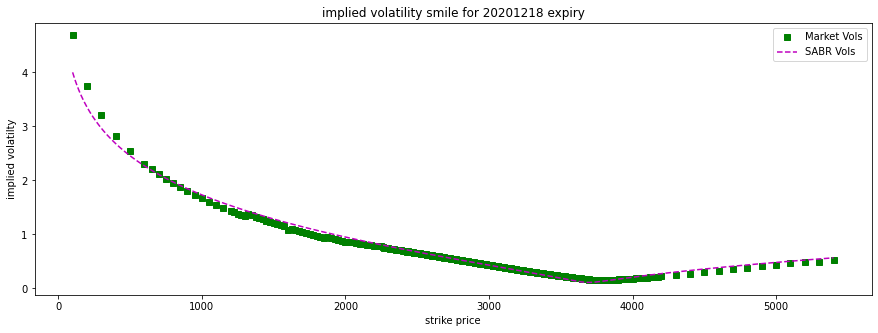

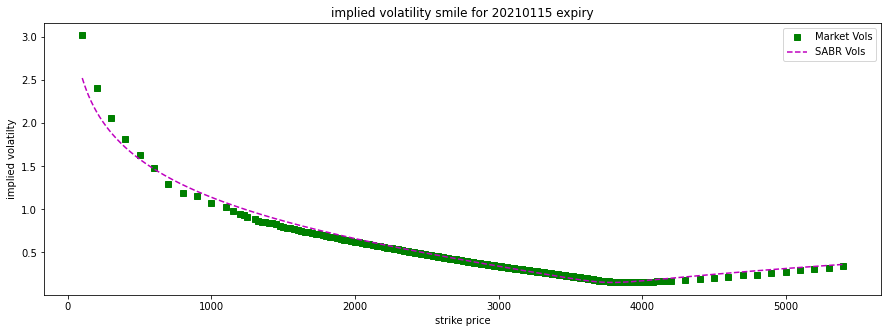

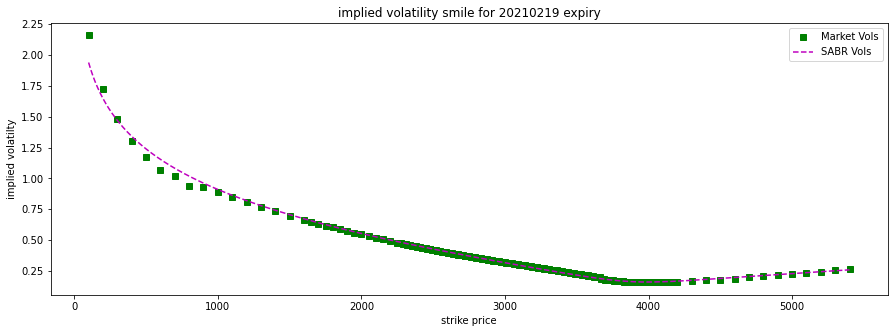

In [32]:
#plot implied vol smile of each expiry


plt.figure(figsize = (15,5))

plt.plot(df_spx_dec["strike_price"], df_spx_dec['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes_dec_spx, sabrvols_dec_spx, 'm--', label='SABR Vols')

plt.legend()
plt.title(f"implied volatility smile for {df_spx_dec['exdate'].iloc[0]} expiry")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()

###############

plt.figure(figsize = (15,5))

plt.plot(df_spx_jan["strike_price"], df_spx_jan['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes_jan_spx, sabrvols_jan_spx, 'm--', label='SABR Vols')

plt.legend()
plt.title(f"implied volatility smile for {df_spx_jan['exdate'].iloc[0]} expiry")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()

####################

plt.figure(figsize = (15,5))

plt.plot(df_spx_feb["strike_price"], df_spx_feb['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes_feb_spx, sabrvols_feb_spx, 'm--', label='SABR Vols')

plt.legend()
plt.title(f"implied volatility smile for {df_spx_feb['exdate'].iloc[0]} expiry")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()

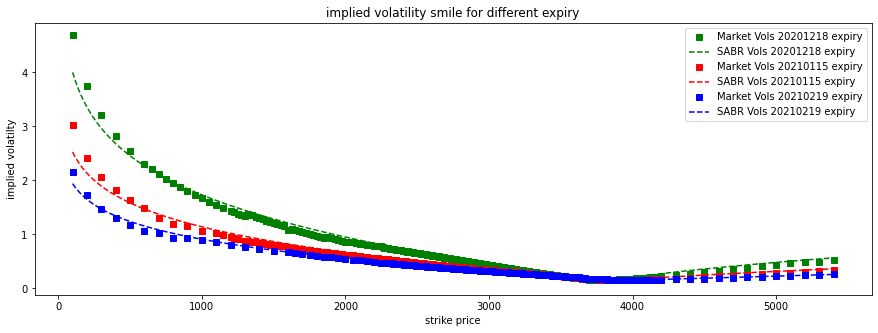

In [33]:
plt.figure(figsize = (15,5))

plt.plot(df_spx_dec["strike_price"], df_spx_dec['impliedvol'], 'gs', label=f'Market Vols {df_spx_dec["exdate"].iloc[0]} expiry')
plt.plot(strikes_dec_spx, sabrvols_dec_spx, 'g--', label= f'SABR Vols {df_spx_dec["exdate"].iloc[0]} expiry')

plt.plot(df_spx_jan["strike_price"], df_spx_jan['impliedvol'], 'rs', label=f'Market Vols {df_spx_jan["exdate"].iloc[0]} expiry')
plt.plot(strikes_jan_spx, sabrvols_jan_spx, 'r--', label=f'SABR Vols {df_spx_jan["exdate"].iloc[0]} expiry')

plt.plot(df_spx_feb["strike_price"], df_spx_feb['impliedvol'], 'bs', label=f'Market Vols {df_spx_feb["exdate"].iloc[0]} expiry')
plt.plot(strikes_feb_spx, sabrvols_feb_spx, 'b--', label=f'SABR Vols {df_spx_feb["exdate"].iloc[0]} expiry')

plt.legend()
plt.title(f"implied volatility smile for different expiry")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()

#### SABR model for SPY

In [34]:
df_spy_dec = df_spy_otm[df_spy_otm["exdate"] == 20201218].reset_index(drop = True)
df_spy_jan = df_spy_otm[df_spy_otm["exdate"] == 20210115].reset_index(drop = True)
df_spy_feb = df_spy_otm[df_spy_otm["exdate"] == 20210219].reset_index(drop = True)

In [35]:
#tune parameter for options vol smile for each expiry

tuned_params_spy = {}
for df_spy_mth, mth in zip( [df_spy_dec,df_spy_jan, df_spy_feb],  ["20201218", "20210115", "20210219"]):
    initialGuess = [0.02, 0.2, 0.1]
    res = least_squares(lambda x: sabrcalibration(x,
                                                  df_spy_mth['strike_price'],
                                                  df_spy_mth['impliedvol'],
                                                  df_spy_mth["F"].iloc[0],
                                                  df_spy_mth["T"].iloc[0]),
                        initialGuess)
    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]

    tuned_params_spy[mth] = (alpha, beta, rho, nu)

    print('Calibrated SABR model parameters for %s expiry: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (mth, alpha, beta, rho, nu))

Calibrated SABR model parameters for 20201218 expiry: alpha = 0.665, beta = 0.7, rho = -0.412, nu = 5.250
Calibrated SABR model parameters for 20210115 expiry: alpha = 0.908, beta = 0.7, rho = -0.489, nu = 2.729


C:\Users\Statistician\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


Calibrated SABR model parameters for 20210219 expiry: alpha = 1.121, beta = 0.7, rho = -0.633, nu = 1.742


In [36]:
#using calibrated SABR parameters to calculate implied vol at each strike for plotting purpose

strikes_dec_spy = np.arange(df_spy_dec["strike_price"].min(), df_spy_dec["strike_price"].max()+5 , 5)
strikes_jan_spy = np.arange(df_spy_jan["strike_price"].min(), df_spy_jan["strike_price"].max()+5 , 5)
strikes_feb_spy = np.arange(df_spy_feb["strike_price"].min(), df_spy_feb["strike_price"].max()+5 , 5)

sabrvols_dec_spy = []
for K in strikes_dec_spy:
    sabrvols_dec_spy.append(SABR(df_spy_dec["F"].iloc[0], K, df_spy_dec["T"].iloc[0], 
                             tuned_params_spy["20201218"][0],tuned_params_spy["20201218"][1], 
                                 tuned_params_spy["20201218"][2], tuned_params_spy["20201218"][3]))
    
sabrvols_jan_spy = []
for K in strikes_jan_spy:
    sabrvols_jan_spy.append(SABR(df_spy_jan["F"].iloc[0], K, df_spy_jan["T"].iloc[0], 
                             tuned_params_spy["20210115"][0],tuned_params_spy["20210115"][1], 
                                 tuned_params_spy["20210115"][2], tuned_params_spy["20210115"][3]))
    
sabrvols_feb_spy = []
for K in strikes_feb_spy:
    sabrvols_feb_spy.append(SABR(df_spy_feb["F"].iloc[0], K, df_spy_feb["T"].iloc[0], 
                             tuned_params_spy["20210219"][0],tuned_params_spy["20210219"][1], 
                                 tuned_params_spy["20210219"][2], tuned_params_spy["20210219"][3]))

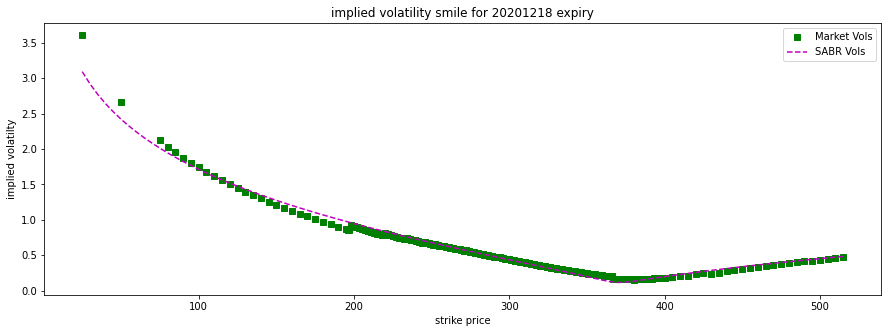

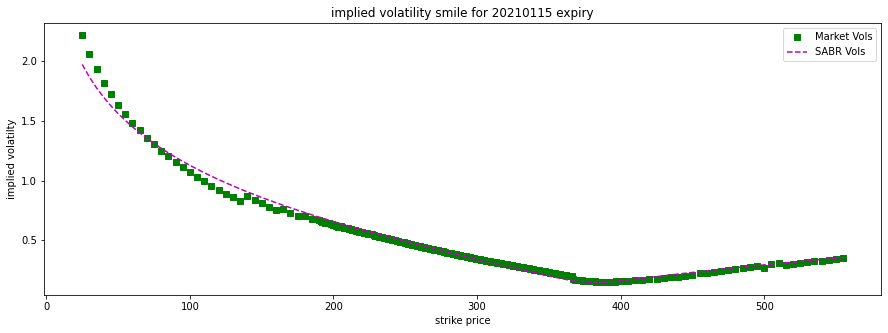

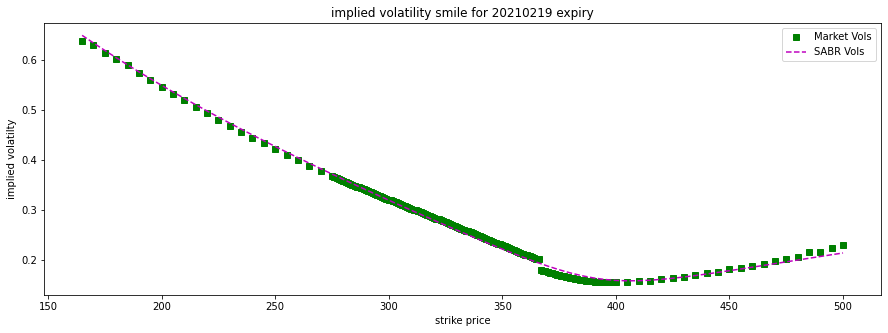

In [37]:
#plot implied vol smile of each expiry

for df_spy_mth, strikes_mth_spy, sabrvols_mth_spy in zip ([df_spy_dec, df_spy_jan,df_spy_feb],
                                                                            [strikes_dec_spy, strikes_jan_spy, strikes_feb_spy],
                                                                          [sabrvols_dec_spy, sabrvols_jan_spy, sabrvols_feb_spy]):
    plt.figure(figsize = (15,5))
    plt.plot(df_spy_mth["strike_price"], df_spy_mth['impliedvol'], 'gs', label='Market Vols')
    plt.plot(strikes_mth_spy, sabrvols_mth_spy, 'm--', label='SABR Vols')

    plt.legend()
    plt.title(f"implied volatility smile for {df_spy_mth['exdate'].iloc[0]} expiry")
    plt.xlabel("strike price")
    plt.ylabel("implied volatilty")
    plt.show()


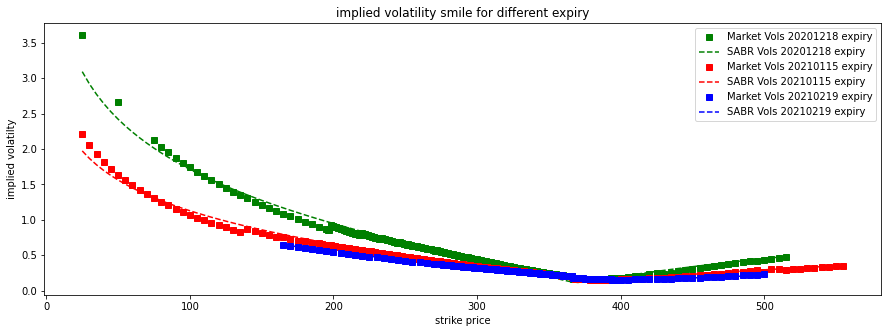

In [38]:
plt.figure(figsize = (15,5))

for df_spy_mth, strikes_mth_spy, sabrvols_mth_spy, colour in zip ([df_spy_dec, df_spy_jan,df_spy_feb],
                                                                            [strikes_dec_spy, strikes_jan_spy, strikes_feb_spy],
                                                                          [sabrvols_dec_spy, sabrvols_jan_spy, sabrvols_feb_spy],
                                                                         ["g","r", "b"]):

    plt.plot(df_spy_mth["strike_price"], df_spy_mth['impliedvol'], f'{colour}s', label=f'Market Vols {df_spy_mth["exdate"].iloc[0]} expiry')
    plt.plot(strikes_mth_spy, sabrvols_mth_spy, f'{colour}--', label= f'SABR Vols {df_spy_mth["exdate"].iloc[0]} expiry')

plt.legend()
plt.title(f"implied volatility smile for different expiry")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()

## calibrate DD model

In [39]:
def DisplacedDiffused(c_or_p, B, F, K, r, sigma,T):
    
    d1 = ( np.log(F/(K*B-F*B+F)) + (B**2*sigma**2*T/2) )/ (B*sigma*np.sqrt(T))
    d2 = d1 - (B * sigma*np.sqrt(T))
    
    if c_or_p == "C":
        return np.exp(-r*T)*( F/B*norm.cdf(d1) - (K + ((1-B)*F/B) )*norm.cdf(d2))
    if c_or_p == "P":
        return np.exp(-r*T)*( -F/B*norm.cdf(-d1) + (K + ((1-B)*F/B) )*norm.cdf(-d2))
    raise KeyError(c_or_p)

In [40]:
def impliedDDVolatility(F, K,T, r,price, B, c_or_p ):
    impliedVol = brentq(lambda x: price -
                        DisplacedDiffused(c_or_p, B, F, K, r, x,T),
                        -1e-12, 10 )

    return impliedVol

In [41]:
def impliedVolatility_BS(S, K, r, price, T, payoff):
    if (payoff.lower() == 'c'):
        impliedVol = brentq(lambda x: price -
                            BlackScholesCall(S, K, r, x, T),
                            -10, 10.0)
    elif (payoff.lower() == 'p'):
        impliedVol = brentq(lambda x: price -
                            BlackScholesPut(S, K, r, x, T),
                            -10, 10.0)
    else:
        raise NameError('Payoff type not recognized')
        print('ex')
        impliedVol = np.nan

    return impliedVol

### dd model for SPX

In [42]:
df_spx_dec = df_spx_otm[df_spx_otm["exdate"] == 20201218].reset_index(drop = True)
df_spx_jan = df_spx_otm[df_spx_otm["exdate"] == 20210115].reset_index(drop = True)
df_spx_feb = df_spx_otm[df_spx_otm["exdate"] == 20210219].reset_index(drop = True)

##### SPX Dec expiry

In [43]:
## get implied vol, mid price and strike of OTM put/call nearest to ATM

df_spx_dec_c = df_spx_dec[df_spx_dec["cp_flag"] == "C"]
call_otm_implied_vol_dec = df_spx_dec_c.loc[(df_spx_dec_c["strike_price"] - spx_underlying).idxmin()]["impliedvol"]
call_otm_midprice_dec = df_spx_dec_c.loc[(df_spx_dec_c["strike_price"] - spx_underlying).idxmin()]["mid_price"]
call_otm_K_dec = df_spx_dec_c.loc[(df_spx_dec_c["strike_price"] - spx_underlying).idxmin()]["strike_price"]

df_spx_dec_p = df_spx_dec[df_spx_dec["cp_flag"] == "P"]
put_otm_implied_vol_dec = df_spx_dec_p.loc[(spx_underlying - df_spx_dec_p["strike_price"] ).idxmin()]["impliedvol"]
put_otm_midprice_dec = df_spx_dec_p.loc[(spx_underlying - df_spx_dec_p["strike_price"] ).idxmin()]["mid_price"]
put_otm_K_dec = df_spx_dec_p.loc[(spx_underlying - df_spx_dec_p["strike_price"] ).idxmin()]["strike_price"]


In [44]:
def ddcalibration_dec(x, strikes, vols, F, T, r, prices, c_or_p):
    
    #given B, calculate sigmaDD using interpolation of implied DD from OTM call and OTM put closest to ATM
    impliedDDVol_put = impliedDDVolatility(F, put_otm_K_dec,T, r,put_otm_midprice_dec, x[0], "P" )
    impliedDDVol_call = impliedDDVolatility(F, call_otm_K_dec,T, r,call_otm_midprice_dec, x[0], "C" )
    impliedDDVol_atm = interpolate( call_otm_K_dec, impliedDDVol_call, put_otm_K_dec, impliedDDVol_put, spx_underlying)
    #impliedDDVol_atm = 0.5*(impliedDDVol_call +  impliedDDVol_put)
    
    err = 0.0
    for i, vol in enumerate(vols):
        price = DisplacedDiffused(c_or_p[i], x[0], F,  strikes[i], r, impliedDDVol_atm,T)
        vol_implied = impliedVolatility_BS(spx_underlying, strikes[i], r, price, T, c_or_p[i])
        
        err += (vol - vol_implied )**2
    
    return err

In [45]:
#Dec tuning


initialGuess = [1.0]
res = least_squares(lambda x: ddcalibration_dec(x,
                                              df_spx_dec['strike_price'],
                                              df_spx_dec['impliedvol'],
                                              df_spx_dec["F"].iloc[0],
                                              df_spx_dec["T"].iloc[0],
                                                df_spx_dec["r"].iloc[0],
                                                df_spx_dec["mid_price"],
                                                df_spx_dec["cp_flag"]),
                    initialGuess, bounds=([0, 1])) 
                    
beta = res.x[0]


tuned_params_dec = beta
tuned_params_dec

3.553045979946385e-08

In [46]:
#find sigma DD based on this tuning
## calculate implied DD sigma by interpolating implied DD from OTM call and OTM put closest to ATM

F = df_spx_dec["F"].iloc[0]
T = df_spx_dec["T"].iloc[0]
r = df_spx_dec["r"].iloc[0]
B = tuned_params_dec


impliedDDVol_put = impliedDDVolatility(F, put_otm_K_dec,T, r,put_otm_midprice_dec, B, "P" )
impliedDDVol_call = impliedDDVolatility(F, call_otm_K_dec,T, r,call_otm_midprice_dec, B, "C" )
sigmaDD = interpolate( call_otm_K_dec, impliedDDVol_call, put_otm_K_dec, impliedDDVol_put, spx_underlying)
#sigmaDD = 0.5*(impliedDDVol_call +  impliedDDVol_put)
sigmaDD

0.17446860357356456

In [47]:
print(f"sigma and beta for dec tuning are {sigmaDD} and {tuned_params_dec} respectively")

sigma and beta for dec tuning are 0.17446860357356456 and 3.553045979946385e-08 respectively


In [48]:
strikes_dec = np.arange(df_spx_dec["strike_price"].min(), df_spx_dec["strike_price"].max()+5 , 5)
strikes_dec

array([ 100.,  105.,  110., ..., 5390., 5395., 5400.])

In [49]:
#use DD model at OTM to get implied vol 

S = spx_underlying
price_dict = {}
impliedvol_dict = {}

B = tuned_params_dec


for K in strikes_dec:
    if K < spx_underlying:
        cp = "P"
    else:
        cp = "C"

    price = DisplacedDiffused(cp, B, F, K, r, sigmaDD,T)
    price_dict[K] = price
    
    impliedDDVol = impliedVolatility(S, K, r, price, T, cp)
    impliedvol_dict[K] = impliedDDVol

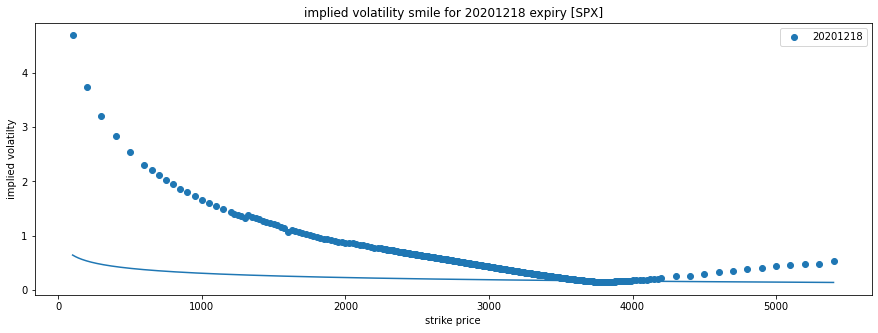

In [50]:
plt.figure(figsize = (15,5))
df_dec = pd.Series(impliedvol_dict, name = "vol").to_frame()
plt.plot(df_dec)
exdate_gb = df_spx_otm.groupby("exdate")
#plt.xlim([0, 4500])


for i, df in exdate_gb:
    if i == 20201218:
        plt.scatter(df["strike_price"],df["impliedvol"], label = i, )
    #break
plt.legend()
plt.title("implied volatility smile for 20201218 expiry [SPX]")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()



##### SPX Jan expiry

In [51]:
## get implied vol, mid price and strike of OTM put/call nearest to ATM

df_spx_jan_c = df_spx_jan[df_spx_jan["cp_flag"] == "C"]
call_otm_implied_vol_jan = df_spx_jan_c.loc[(df_spx_jan_c["strike_price"] - spx_underlying).idxmin()]["impliedvol"]
call_otm_midprice_jan = df_spx_jan_c.loc[(df_spx_jan_c["strike_price"] - spx_underlying).idxmin()]["mid_price"]
call_otm_K_jan = df_spx_jan_c.loc[(df_spx_jan_c["strike_price"] - spx_underlying).idxmin()]["strike_price"]

df_spx_jan_p = df_spx_jan[df_spx_jan["cp_flag"] == "P"]
put_otm_implied_vol_jan = df_spx_jan_p.loc[(spx_underlying - df_spx_jan_p["strike_price"] ).idxmin()]["impliedvol"]
put_otm_midprice_jan = df_spx_jan_p.loc[(spx_underlying - df_spx_jan_p["strike_price"] ).idxmin()]["mid_price"]
put_otm_K_jan = df_spx_jan_p.loc[(spx_underlying - df_spx_jan_p["strike_price"] ).idxmin()]["strike_price"]

In [52]:
def ddcalibration_jan(x, strikes, vols, F, T, r, prices, c_or_p):
    
    #given B, calculate sigmaDD using interpolation of implied DD from OTM call and OTM put closest to ATM
    impliedDDVol_put = impliedDDVolatility(F, put_otm_K_jan,T, r,put_otm_midprice_jan, x[0], "P" )
    impliedDDVol_call = impliedDDVolatility(F, call_otm_K_jan,T, r,call_otm_midprice_jan, x[0], "C" )
    impliedDDVol_atm = interpolate( call_otm_K_jan, impliedDDVol_call, put_otm_K_jan, impliedDDVol_put, spx_underlying)
    
    err = 0.0
    for i, vol in enumerate(vols):
        price = DisplacedDiffused(c_or_p[i], x[0], F,  strikes[i], r, impliedDDVol_atm,T)
        vol_implied = impliedVolatility(spx_underlying, strikes[i], r, price, T, c_or_p[i])
        
        err += (vol - vol_implied )**2
    
    return err

In [53]:
#Jan tuning
initialGuess = [0.5]
res = least_squares(lambda x: ddcalibration_jan(x,
                                              df_spx_jan['strike_price'],
                                              df_spx_jan['impliedvol'],
                                              df_spx_jan["F"].iloc[0],
                                              df_spx_jan["T"].iloc[0],
                                                df_spx_jan["r"].iloc[0],
                                                df_spx_jan["mid_price"],
                                                df_spx_jan["cp_flag"]),
                    initialGuess 
                    ,bounds=([0, 1])) 
                    
beta = res.x[0]


tuned_params_jan = beta
tuned_params_jan

4.875512092089268e-07

In [54]:
#find sigma DD based on this tuning
## get implied vol, mid price and strike of OTM put/call nearest to ATM


F = df_spx_jan["F"].iloc[0]
T = df_spx_jan["T"].iloc[0]
r = df_spx_jan["r"].iloc[0]
B = tuned_params_jan


impliedDDVol_put = impliedDDVolatility(F, put_otm_K_jan,T, r,put_otm_midprice_jan, B, "P" )
impliedDDVol_call = impliedDDVolatility(F, call_otm_K_jan,T, r,call_otm_midprice_jan, B, "C" )
sigmaDD = interpolate( call_otm_K_jan, impliedDDVol_call, put_otm_K_jan, impliedDDVol_put, spx_underlying)
#sigmaDD = 0.5*(impliedDDVol_call +  impliedDDVol_put)
sigmaDD

0.18485237891943054

In [55]:
print(f"sigma and beta for jan tuning are {sigmaDD} and {tuned_params_jan} respectively")

sigma and beta for jan tuning are 0.18485237891943054 and 4.875512092089268e-07 respectively


In [56]:
strikes_jan = np.arange(df_spx_jan["strike_price"].min(), df_spx_jan["strike_price"].max()+5 , 5)

In [57]:
#use DD model at OTM to get implied vol 

S = spx_underlying
price_dict = {}
impliedvol_dict = {}

B = tuned_params_jan

for K in strikes_jan:
    if K < spx_underlying:
        cp = "P"
    else:
        cp = "C"
    price = DisplacedDiffused(cp, B, F, K, r, sigmaDD,T)
    price_dict[K] = price
    impliedDDVol = impliedVolatility(S, K, r, price, T, cp)
    impliedvol_dict[K] = impliedDDVol

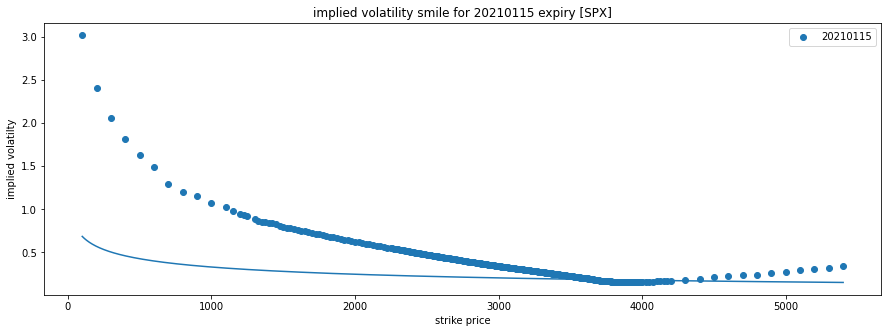

In [58]:
plt.figure(figsize = (15,5))
df_jan = pd.Series(impliedvol_dict, name = "vol").to_frame()
plt.plot(df_jan)
exdate_gb = df_spx_otm.groupby("exdate")
#plt.xlim([0, 4500])


for i, df in exdate_gb:
    if i == 20210115:
        plt.scatter(df["strike_price"],df["impliedvol"], label = i, )
    #break
plt.legend()
plt.title("implied volatility smile for 20210115 expiry [SPX]")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()

##### SPX Feb expiry

In [59]:
## get implied vol, mid price and strike of OTM put/call nearest to ATM

df_spx_feb_c = df_spx_feb[df_spx_feb["cp_flag"] == "C"]
call_otm_implied_vol_feb = df_spx_feb_c.loc[(df_spx_feb_c["strike_price"] - spx_underlying).idxmin()]["impliedvol"]
call_otm_midprice_feb = df_spx_feb_c.loc[(df_spx_feb_c["strike_price"] - spx_underlying).idxmin()]["mid_price"]
call_otm_K_feb = df_spx_feb_c.loc[(df_spx_feb_c["strike_price"] - spx_underlying).idxmin()]["strike_price"]

df_spx_feb_p = df_spx_feb[df_spx_feb["cp_flag"] == "P"]
put_otm_implied_vol_feb = df_spx_feb_p.loc[(spx_underlying - df_spx_feb_p["strike_price"] ).idxmin()]["impliedvol"]
put_otm_midprice_feb = df_spx_feb_p.loc[(spx_underlying - df_spx_feb_p["strike_price"] ).idxmin()]["mid_price"]
put_otm_K_feb = df_spx_feb_p.loc[(spx_underlying - df_spx_feb_p["strike_price"] ).idxmin()]["strike_price"]

In [60]:
def ddcalibration_feb(x, strikes, vols, F, T, r, prices, c_or_p):
    #given B, calculate sigmaDD using interpolation of implied DD from OTM call and OTM put closest to ATM
    impliedDDVol_put = impliedDDVolatility(F, put_otm_K_feb,T, r,put_otm_midprice_feb, x[0], "P" )
    impliedDDVol_call = impliedDDVolatility(F, call_otm_K_feb,T, r,call_otm_midprice_feb, x[0], "C" )
    impliedDDVol_atm = interpolate( call_otm_K_feb, impliedDDVol_call, put_otm_K_feb, impliedDDVol_put, spx_underlying)
    
    err = 0.0
    for i, vol in enumerate(vols):
        price = DisplacedDiffused(c_or_p[i], x[0], F,  strikes[i], r, impliedDDVol_atm,T)
        vol_implied = impliedVolatility(spx_underlying, strikes[i], r, price, T, c_or_p[i])
        
        err += (vol - vol_implied )**2
    
    return err

In [61]:
#Feb tuning
initialGuess = [0.9]
res = least_squares(lambda x: ddcalibration_feb(x,
                                              df_spx_feb['strike_price'],
                                              df_spx_feb['impliedvol'],
                                              df_spx_feb["F"].iloc[0],
                                              df_spx_feb["T"].iloc[0],
                                                df_spx_feb["r"].iloc[0],
                                                df_spx_feb["mid_price"],
                                                df_spx_feb["cp_flag"]),
                    initialGuess 
                    ,bounds=([0, 1])) 
                    
beta = res.x[0]


tuned_params_feb = beta
tuned_params_feb

3.2315049264794083e-07

In [62]:
#find sigma DD based on this tuning
## calculate implied DD sigma by interpolating implied DD from OTM call and OTM put closest to ATM

F = df_spx_feb["F"].iloc[0]
T = df_spx_feb["T"].iloc[0]
r = df_spx_feb["r"].iloc[0]
B = tuned_params_feb
#B = 0.5

impliedDDVol_put = impliedDDVolatility(F, put_otm_K_feb,T, r,put_otm_midprice_jan, B, "P" )
impliedDDVol_call = impliedDDVolatility(F, call_otm_K_feb,T, r,call_otm_midprice_jan, B, "C" )
#sigmaDD = 0.5*(impliedDDVol_call +  impliedDDVol_put)
sigmaDD = interpolate( call_otm_K_feb, impliedDDVol_call, put_otm_K_feb, impliedDDVol_put, spx_underlying)
sigmaDD

0.14129109978494148

In [63]:
print(f"sigma and beta for feb tuning are {sigmaDD} and {tuned_params_feb} respectively")

sigma and beta for feb tuning are 0.14129109978494148 and 3.2315049264794083e-07 respectively


In [64]:
strikes_feb = np.arange(df_spx_feb["strike_price"].min(), df_spx_feb["strike_price"].max()+5 , 5)

In [65]:
S = spx_underlying
price_dict = {}
impliedvol_dict = {}

B = tuned_params_feb

for K in strikes_feb:
    if K < spx_underlying:
        cp = "P"
    else:
        cp = "C"
    price = DisplacedDiffused(cp, B, F, K, r, sigmaDD,T)
    price_dict[K] = price
    impliedDDVol = impliedVolatility(S, K, r, price, T, cp)
    impliedvol_dict[K] = impliedDDVol

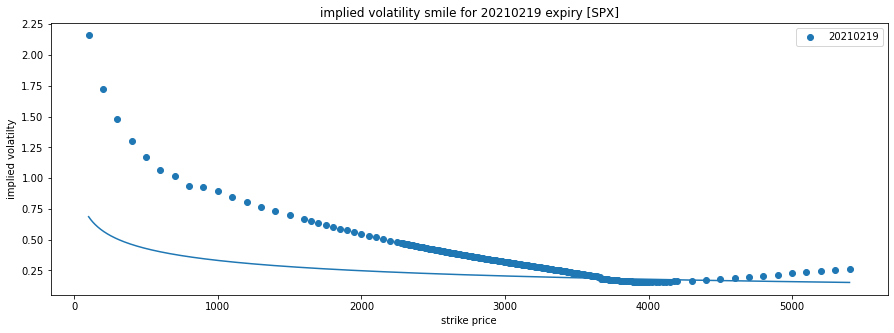

In [66]:
plt.figure(figsize = (15,5))
df_feb = pd.Series(impliedvol_dict, name = "vol").to_frame()
plt.plot(df_jan)
exdate_gb = df_spx_otm.groupby("exdate")
#plt.xlim([0, 4500])


for i, df in exdate_gb:
    if i == 20210219:
        plt.scatter(df["strike_price"],df["impliedvol"], label = i, )
    #break
plt.legend()
plt.title("implied volatility smile for 20210219 expiry [SPX]")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()

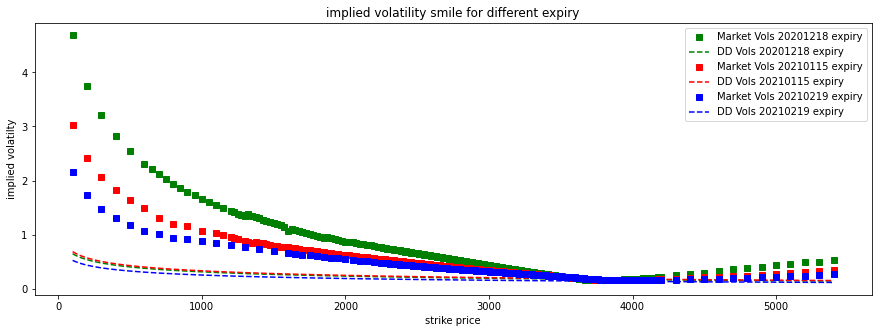

In [67]:
plt.figure(figsize = (15,5))

plt.plot(df_spx_dec["strike_price"], df_spx_dec['impliedvol'], 'gs', label=f'Market Vols {df_spx_dec["exdate"].iloc[0]} expiry')
plt.plot(df_dec, 'g--', label= f'DD Vols {df_spx_dec["exdate"].iloc[0]} expiry')

plt.plot(df_spx_jan["strike_price"], df_spx_jan['impliedvol'], 'rs', label=f'Market Vols {df_spx_jan["exdate"].iloc[0]} expiry')
plt.plot(df_jan, 'r--', label=f'DD Vols {df_spx_jan["exdate"].iloc[0]} expiry')

plt.plot(df_spx_feb["strike_price"], df_spx_feb['impliedvol'], 'bs', label=f'Market Vols {df_spx_feb["exdate"].iloc[0]} expiry')
plt.plot(df_feb, 'b--', label=f'DD Vols {df_spx_feb["exdate"].iloc[0]} expiry')

plt.legend()
plt.title(f"implied volatility smile for different expiry")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()

### DD tuning for SPY

In [68]:
df_spy_dec = df_spy_otm[df_spy_otm["exdate"] == 20201218].reset_index(drop = True)
df_spy_jan = df_spy_otm[df_spy_otm["exdate"] == 20210115].reset_index(drop = True)
df_spy_feb = df_spy_otm[df_spy_otm["exdate"] == 20210219].reset_index(drop = True)

##### SPY dec expiry

In [70]:
## get implied vol, mid price and strike of OTM put/call nearest to ATM

df_spy_dec_c = df_spy_dec[df_spy_dec["cp_flag"] == "C"]
call_otm_implied_vol_dec = df_spy_dec_c.loc[(df_spy_dec_c["strike_price"] - spy_underlying).idxmin()]["impliedvol"]
call_otm_midprice_dec = df_spy_dec_c.loc[(df_spy_dec_c["strike_price"] - spy_underlying).idxmin()]["mid_price"]
call_otm_K_dec = df_spy_dec_c.loc[(df_spy_dec_c["strike_price"] - spy_underlying).idxmin()]["strike_price"]

df_spy_dec_p = df_spy_dec[df_spy_dec["cp_flag"] == "P"]
put_otm_implied_vol_dec = df_spy_dec_p.loc[(spy_underlying - df_spy_dec_p["strike_price"] ).idxmin()]["impliedvol"]
put_otm_midprice_dec = df_spy_dec_p.loc[(spy_underlying - df_spy_dec_p["strike_price"] ).idxmin()]["mid_price"]
put_otm_K_dec = df_spy_dec_p.loc[(spy_underlying - df_spy_dec_p["strike_price"] ).idxmin()]["strike_price"]

In [71]:
#given B, calculate sigmaDD using interpolation of implied DD from OTM call and OTM put closest to ATM
def ddcalibration2_dec(x, strikes, vols, F, T, r, prices, c_or_p):
    impliedDDVol_put = impliedDDVolatility(F, put_otm_K_dec,T, r,put_otm_midprice_dec, x[0], "P" )
    impliedDDVol_call = impliedDDVolatility(F, call_otm_K_dec,T, r,call_otm_midprice_dec, x[0], "C" )
    impliedDDVol_atm = interpolate( call_otm_K_dec, impliedDDVol_call, put_otm_K_dec, impliedDDVol_put, spy_underlying)

    
    err = 0.0
    for i, vol in enumerate(vols):
        price = DisplacedDiffused(c_or_p[i], x[0], F,  strikes[i], r, impliedDDVol_atm,T)
        vol_implied = impliedVolatility(spy_underlying, strikes[i], r, price, T, c_or_p[i])
        
        err += (vol - vol_implied )**2
    
    return err

In [72]:
#Dec tuning
initialGuess = [0.1]
res = least_squares(lambda x: ddcalibration2_dec(x,
                                              df_spy_dec['strike_price'],
                                              df_spy_dec['impliedvol'],
                                              df_spy_dec["F"].iloc[0],
                                              df_spy_dec["T"].iloc[0],
                                                df_spy_dec["r"].iloc[0],
                                                df_spy_dec["mid_price"],
                                                df_spy_dec["cp_flag"]),
                    initialGuess 
                    ,bounds=([0, 1])) 
                    
beta = res.x[0]


tuned_params_dec = beta
tuned_params_dec

6.204151419099215e-07

In [73]:
#find sigma DD based on this tuning
## calculate implied DD sigma by interpolating implied DD vol from OTM call and OTM put closest to ATM

F = df_spy_dec["F"].iloc[0]
T = df_spy_dec["T"].iloc[0]
r = df_spy_dec["r"].iloc[0]
B = tuned_params_dec


impliedDDVol_put = impliedDDVolatility(F, put_otm_K_dec,T, r,put_otm_midprice_dec, B, "P" )
impliedDDVol_call = impliedDDVolatility(F, call_otm_K_dec,T, r,call_otm_midprice_dec, B, "C" )
sigmaDD = interpolate( call_otm_K_dec, impliedDDVol_call, put_otm_K_dec, impliedDDVol_put, spy_underlying)
sigmaDD

0.20088304154323808

In [74]:
print(f"sigma and beta for dec tuning are {sigmaDD} and {tuned_params_dec} respectively")

sigma and beta for dec tuning are 0.20088304154323808 and 6.204151419099215e-07 respectively


In [75]:
strikes_dec = np.arange(df_spy_dec["strike_price"].min(), df_spy_dec["strike_price"].max()+5 , 5)

In [76]:
#use DD model at OTM to get implied vol 

S = spy_underlying
price_dict = {}
impliedvol_dict = {}

B = tuned_params_dec
#B = 0.5

for K in strikes_dec:
    if K < spy_underlying:
        cp = "P"
    else:
        cp = "C"

    price = DisplacedDiffused(cp, B, F, K, r, sigmaDD,T)
    price_dict[K] = price
    
    impliedDDVol = impliedVolatility(S, K, r, price, T, cp)
    impliedvol_dict[K] = impliedDDVol

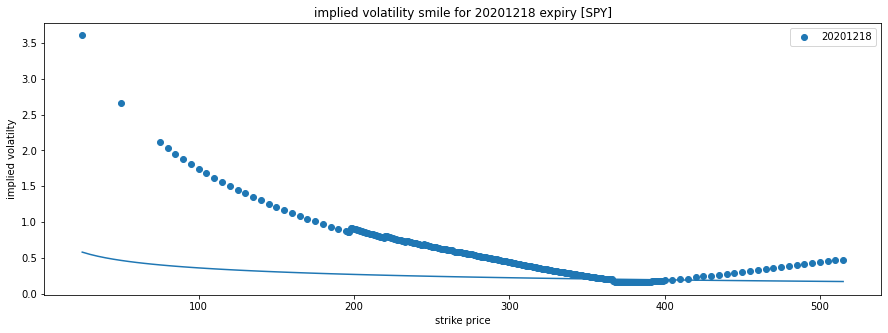

In [77]:
plt.figure(figsize = (15,5))
df_dec = pd.Series(impliedvol_dict, name = "vol").to_frame()
plt.plot(df_dec)
exdate_gb = df_spy_otm.groupby("exdate")

for i, df in exdate_gb:
    if i == 20201218:
        plt.scatter(df["strike_price"],df["impliedvol"], label = i, )
    #break
plt.legend()
plt.title("implied volatility smile for 20201218 expiry [SPY]")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()

##### SPY jan expiry

In [78]:
## get implied vol, mid price and strike of OTM put/call nearest to ATM

df_spy_jan_c = df_spy_jan[df_spy_jan["cp_flag"] == "C"]
call_otm_implied_vol_jan = df_spy_jan_c.loc[(df_spy_jan_c["strike_price"] - spy_underlying).idxmin()]["impliedvol"]
call_otm_midprice_jan = df_spy_jan_c.loc[(df_spy_jan_c["strike_price"] - spy_underlying).idxmin()]["mid_price"]
call_otm_K_jan = df_spy_jan_c.loc[(df_spy_jan_c["strike_price"] - spy_underlying).idxmin()]["strike_price"]

df_spy_jan_p = df_spy_jan[df_spy_jan["cp_flag"] == "P"]
put_otm_implied_vol_jan = df_spy_jan_p.loc[(spy_underlying - df_spy_jan_p["strike_price"] ).idxmin()]["impliedvol"]
put_otm_midprice_jan = df_spy_jan_p.loc[(spy_underlying - df_spy_jan_p["strike_price"] ).idxmin()]["mid_price"]
put_otm_K_jan = df_spy_jan_p.loc[(spy_underlying - df_spy_jan_p["strike_price"] ).idxmin()]["strike_price"]

In [79]:
def ddcalibration2_jan(x, strikes, vols, F, T, r, prices, c_or_p):
    
    #given B, calculate sigmaDD using interpolation of implied DD from OTM call and OTM put closest to ATM
    impliedDDVol_put = impliedDDVolatility(F, put_otm_K_jan,T, r,put_otm_midprice_jan, x[0], "P" )
    impliedDDVol_call = impliedDDVolatility(F, call_otm_K_jan,T, r,call_otm_midprice_jan, x[0], "C" )
    impliedDDVol_atm = interpolate( call_otm_K_jan, impliedDDVol_call, put_otm_K_jan, impliedDDVol_put, spy_underlying)
    
    err = 0.0
    for i, vol in enumerate(vols):
        price = DisplacedDiffused(c_or_p[i], x[0], F,  strikes[i], r, impliedDDVol_atm,T)
        vol_implied = impliedVolatility(spy_underlying, strikes[i], r, price, T, c_or_p[i])
        
        err += (vol - vol_implied )**2
    
    return err

In [80]:
#Jan tuning
initialGuess = [0.5]
res = least_squares(lambda x: ddcalibration2_jan(x,
                                              df_spy_jan['strike_price'],
                                              df_spy_jan['impliedvol'],
                                              df_spy_jan["F"].iloc[0],
                                              df_spy_jan["T"].iloc[0],
                                                df_spy_jan["r"].iloc[0],
                                                df_spy_jan["mid_price"],
                                                df_spy_jan["cp_flag"]),
                    initialGuess 
                    ,bounds=([0, 1])) 
                    
beta = res.x[0]


tuned_params_jan = beta
tuned_params_jan

2.7425676029403398e-08

In [81]:
#find sigma DD based on this tuning
## calculate implied DD sigma by interpolating implied DD vol from OTM call and OTM put closest to ATM

F = df_spy_jan["F"].iloc[0]
T = df_spy_jan["T"].iloc[0]
r = df_spy_jan["r"].iloc[0]
B = tuned_params_jan

impliedDDVol_put = impliedDDVolatility(F, put_otm_K_jan,T, r,put_otm_midprice_jan, B, "P" )
impliedDDVol_call = impliedDDVolatility(F, call_otm_K_jan,T, r,call_otm_midprice_jan, B, "C" )
sigmaDD = interpolate( call_otm_K_jan, impliedDDVol_call, put_otm_K_jan, impliedDDVol_put, spy_underlying)

sigmaDD

0.19715255492414013

In [82]:
print(f"sigma and beta for jan tuning are {sigmaDD} and {tuned_params_jan} respectively")

sigma and beta for jan tuning are 0.19715255492414013 and 2.7425676029403398e-08 respectively


In [83]:
strikes_jan = np.arange(df_spy_jan["strike_price"].min(), df_spy_jan["strike_price"].max()+5 , 5)

In [84]:
#use DD model at OTM to get implied vol 

S = spy_underlying
price_dict = {}
impliedvol_dict = {}

B = tuned_params_jan

for K in strikes_jan:
    if K < spy_underlying:
        cp = "P"
    else:
        cp = "C"
    price = DisplacedDiffused(cp, B, F, K, r, sigmaDD,T)
    price_dict[K] = price
    impliedDDVol = impliedVolatility(S, K, r, price, T, cp)
    impliedvol_dict[K] = impliedDDVol

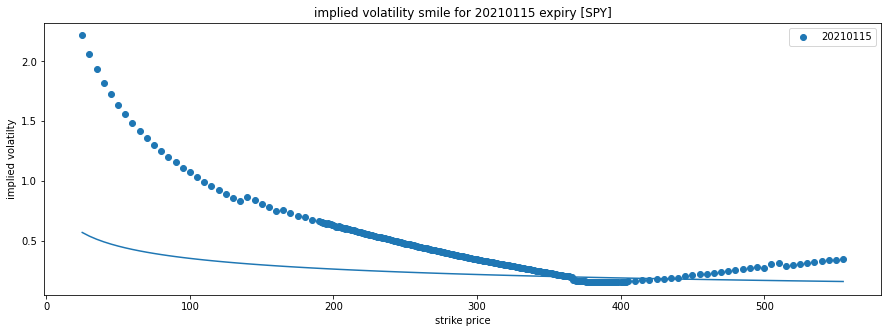

In [85]:
plt.figure(figsize = (15,5))
df_jan = pd.Series(impliedvol_dict, name = "vol").to_frame()
plt.plot(df_jan)
exdate_gb = df_spy_otm.groupby("exdate")

for i, df in exdate_gb:
    if i == 20210115:
        plt.scatter(df["strike_price"],df["impliedvol"], label = i, )
    #break
plt.legend()
plt.title("implied volatility smile for 20210115 expiry [SPY]")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()

##### spy feb tuning

In [117]:
## get implied vol, mid price and strike of OTM put/call nearest to ATM

df_spy_feb_c = df_spy_feb[df_spy_feb["cp_flag"] == "C"]
call_otm_implied_vol_feb = df_spy_feb_c.loc[(df_spy_feb_c["strike_price"] - spy_underlying).idxmin()]["impliedvol"]
call_otm_midprice_feb = df_spy_feb_c.loc[(df_spy_feb_c["strike_price"] - spy_underlying).idxmin()]["mid_price"]
call_otm_K_feb = df_spy_feb_c.loc[(df_spy_feb_c["strike_price"] - spy_underlying).idxmin()]["strike_price"]

df_spy_feb_p = df_spy_feb[df_spy_feb["cp_flag"] == "P"]
put_otm_implied_vol_feb = df_spy_feb_p.loc[(spy_underlying - df_spy_feb_p["strike_price"] ).idxmin()]["impliedvol"]
put_otm_midprice_feb = df_spy_feb_p.loc[(spy_underlying - df_spy_feb_p["strike_price"] ).idxmin()]["mid_price"]
put_otm_K_feb = df_spy_feb_p.loc[(spy_underlying - df_spy_feb_p["strike_price"] ).idxmin()]["strike_price"]

In [118]:
def ddcalibration2_feb(x, strikes, vols, F, T, r, prices, c_or_p):
    
    #given B, calculate sigmaDD using interpolation of implied DD from OTM call and OTM put closest to ATM
    impliedDDVol_put = impliedDDVolatility(F, put_otm_K_feb,T, r,put_otm_midprice_feb, x[0], "P" )
    impliedDDVol_call = impliedDDVolatility(F, call_otm_K_feb,T, r,call_otm_midprice_feb, x[0], "C" )
    impliedDDVol_atm = interpolate( call_otm_K_feb, impliedDDVol_call, put_otm_K_feb, impliedDDVol_put, spy_underlying)
    
    err = 0.0
    for i, vol in enumerate(vols):
        price = DisplacedDiffused(c_or_p[i], x[0], F,  strikes[i], r, impliedDDVol_atm,T)
        vol_implied = impliedVolatility(spy_underlying, strikes[i], r, price, T, c_or_p[i])
        
        err += (vol - vol_implied )**2
    
    return err

In [119]:
#Feb tuning
initialGuess = [0.5]
res = least_squares(lambda x: ddcalibration2_feb(x,
                                              df_spy_feb['strike_price'],
                                              df_spy_feb['impliedvol'],
                                              df_spy_feb["F"].iloc[0],
                                              df_spy_feb["T"].iloc[0],
                                                df_spy_feb["r"].iloc[0],
                                                df_spy_feb["mid_price"],
                                                df_spy_feb["cp_flag"]),
                    initialGuess 
                    ,bounds=([0, 1])) 
                    
beta = res.x[0]


tuned_params_feb = beta
tuned_params_feb

1.0863684862449225e-06

In [120]:
#find sigma DD based on this tuning
## calculate implied DD sigma by interpolating implied DD vol from OTM call and OTM put closest to ATM

F = df_spy_feb["F"].iloc[0]
T = df_spy_feb["T"].iloc[0]
r = df_spy_feb["r"].iloc[0]
B = tuned_params_feb


impliedDDVol_put = impliedDDVolatility(F, put_otm_K_feb,T, r,put_otm_midprice_feb, B, "P" )
impliedDDVol_call = impliedDDVolatility(F, call_otm_K_feb,T, r,call_otm_midprice_feb, B, "C" )
sigmaDD = interpolate( call_otm_K_feb, impliedDDVol_call, put_otm_K_feb, impliedDDVol_put, spy_underlying)
sigmaDD

0.2001179819900697

In [121]:
print(f"sigma and beta for feb tuning are {sigmaDD} and {tuned_params_feb} respectively")

sigma and beta for feb tuning are 0.2001179819900697 and 1.0863684862449225e-06 respectively


In [91]:
strikes_feb = np.arange(df_spy_feb["strike_price"].min(), df_spy_feb["strike_price"].max()+5 , 5)

In [92]:
#use DD model at OTM to get implied vol 

S = spy_underlying
price_dict = {}
impliedvol_dict = {}

B = tuned_params_feb

for K in strikes_feb:
    if K < spy_underlying:
        cp = "P"
    else:
        cp = "C"
    price = DisplacedDiffused(cp, B, F, K, r, sigmaDD,T)
    price_dict[K] = price
    impliedDDVol = impliedVolatility(S, K, r, price, T, cp)
    impliedvol_dict[K] = impliedDDVol

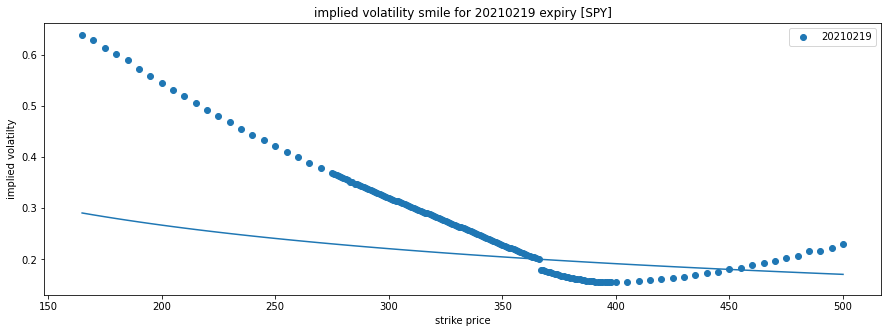

In [93]:
plt.figure(figsize = (15,5))
df_feb = pd.Series(impliedvol_dict, name = "vol").to_frame()
plt.plot(df_feb)
exdate_gb = df_spy_otm.groupby("exdate")
#plt.xlim([0, 4500])


for i, df in exdate_gb:
    if i == 20210219:
        plt.scatter(df["strike_price"],df["impliedvol"], label = i, )
    #break
plt.legend()
plt.title("implied volatility smile for 20210219 expiry [SPY]")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()

##### combined curve for SPY

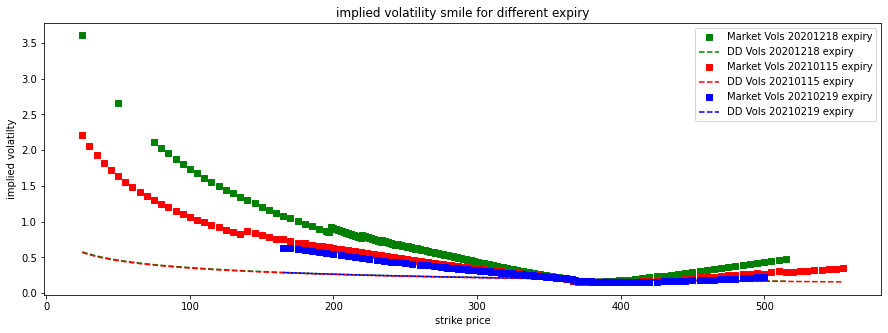

In [94]:
plt.figure(figsize = (15,5))

plt.plot(df_spy_dec["strike_price"], df_spy_dec['impliedvol'], 'gs', label=f'Market Vols {df_spy_dec["exdate"].iloc[0]} expiry')
plt.plot(df_dec, 'g--', label= f'DD Vols {df_spy_dec["exdate"].iloc[0]} expiry')

plt.plot(df_spy_jan["strike_price"], df_spy_jan['impliedvol'], 'rs', label=f'Market Vols {df_spy_jan["exdate"].iloc[0]} expiry')
plt.plot(df_jan, 'r--', label=f'DD Vols {df_spy_jan["exdate"].iloc[0]} expiry')

plt.plot(df_spy_feb["strike_price"], df_spy_feb['impliedvol'], 'bs', label=f'Market Vols {df_spy_feb["exdate"].iloc[0]} expiry')
plt.plot(df_feb, 'b--', label=f'DD Vols {df_spy_feb["exdate"].iloc[0]} expiry')

plt.legend()
plt.title(f"implied volatility smile for different expiry")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()

## How does change in sigma and beta affect the shape of implied volatility

In [147]:
#using last runing (SPY for expiry feb as example)
S = spy_underlying
F = df_spy_feb["F"].iloc[0]
T = df_spy_feb["T"].iloc[0]
r = df_spy_feb["r"].iloc[0]


In [148]:
#take OTM put price nearest to ATM
price_put = df_spy_feb_p.loc[(spy_underlying - df_spy_feb_p["strike_price"] ).idxmin()]["mid_price"]
price_put

13.61

In [149]:
#take OTM put price nearest to ATM
price_call = df_spy_feb_c.loc[(df_spy_feb_c["strike_price"] - spy_underlying ).idxmin()]["mid_price"]
price_call

11.920000000000002

In [150]:
## get implied vol, mid price and strike of OTM put/call nearest to ATM

df_spy_feb_c = df_spy_feb[df_spy_feb["cp_flag"] == "C"]
call_otm_implied_vol_feb = df_spy_feb_c.loc[(df_spy_feb_c["strike_price"] - spy_underlying).idxmin()]["impliedvol"]
call_otm_midprice_feb = df_spy_feb_c.loc[(df_spy_feb_c["strike_price"] - spy_underlying).idxmin()]["mid_price"]
call_otm_K_feb = df_spy_feb_c.loc[(df_spy_feb_c["strike_price"] - spy_underlying).idxmin()]["strike_price"]

df_spy_feb_p = df_spy_feb[df_spy_feb["cp_flag"] == "P"]
put_otm_implied_vol_feb = df_spy_feb_p.loc[(spy_underlying - df_spy_feb_p["strike_price"] ).idxmin()]["impliedvol"]
put_otm_midprice_feb = df_spy_feb_p.loc[(spy_underlying - df_spy_feb_p["strike_price"] ).idxmin()]["mid_price"]
put_otm_K_feb = df_spy_feb_p.loc[(spy_underlying - df_spy_feb_p["strike_price"] ).idxmin()]["strike_price"]

In [151]:
def BachelierVanilla(flag, S, K, r, sigma, T):
    '''This method uses Bachelier model to return European call and put prices in a dictionary'''
    
    x_call = (S-K)/(sigma*np.sqrt(T))
    V_c = np.exp(-r*T)*((S-K)*norm.cdf(x_call) +
                        sigma*np.sqrt(T)*norm.pdf(x_call))

    x_put = (K-S)/(sigma*np.sqrt(T))
    V_p = np.exp(-r*T)*((K-S)*norm.cdf(x_put) +
                        sigma*np.sqrt(T)*norm.pdf(x_put))
    
    if flag == "C":
        prices = V_c
    elif flag == "P":
        prices = V_p
    #print('Bachelier European call/put prices: ')
    #print(prices)

    return prices

def black_scholes_vanilla(flag, S, K, t, r, sigma):
    '''
    This method uses Black Scholes model to return European vanilla call or put prices based on flag c or p
    '''
    d1 = (np.log(S/K) + (r + np.square(sigma)/ 2) * t) / (sigma * np.sqrt(t))
    d2 = (np.log(S/K) + (r - np.square(sigma)/ 2) * t) / (sigma * np.sqrt(t))
    if flag.lower() == "c" :
        return S*norm.cdf(d1) -K*np.power(np.e,-1*r*t)*norm.cdf(d2)
    if flag.lower() == "p":
        return K*np.power(np.e,-1*r*t)*norm.cdf(-1*d2) - S*norm.cdf(-1*d1)
    raise KeyError(flag)

In [152]:
def impliedBachelierPutVolatility(S, K, r, price, T):
    
    impliedVol = brentq(lambda x: price -
                    BachelierVanilla("P", S, K, r, x, T),
                    1e06, 1)
    return impliedVol

def impliedBachelierCallVolatility(S, K, r, price, T):

    
    impliedVol = brentq(lambda x: price -
                    BachelierVanilla("C", S, K, r, x, T),
                    1e06, 1)

    return impliedVol

## calculate implied bachelier sigma by interpolating implied bacheleir vol from OTM call and OTM put closest to ATM
sigmaN_put = impliedBachelierPutVolatility(S, put_otm_K_feb, r, price_put, T)
sigmaN_call = impliedBachelierCallVolatility(S, call_otm_K_feb, r, price_call, T)
sigmaN = interpolate(call_otm_K_feb, sigmaN_call, put_otm_K_feb, sigmaN_put,S )
sigmaN

72.82858014820978

In [131]:
## calculate implied black scholes sigma by interpolating implied BS vol from OTM call and OTM put closest to ATM

sigmaBS_put = impliedVolatility(S, put_otm_K_feb, r, price_put, T, "P")
sigmaBS_call = impliedVolatility(S, call_otm_K_feb, r, price_call, T, "C")
sigmaBS = interpolate(call_otm_K_feb, sigmaBS_call, put_otm_K_feb, sigmaBS_put,S )
sigmaBS

0.20024026777979104

In [134]:
#Assume B =0.5 for illustration purpose
B = 0.5

## calculate implied DD sigma by interpolating implied DD vol from OTM call and OTM put closest to ATM
sigmaDD_put =  impliedDDVolatility(F, put_otm_K_feb,T, r,price_put, B, "P" )
sigmaDD_call =  impliedDDVolatility(F, call_otm_K_feb,T, r,price_call, B, "C" )
sigmaDD = interpolate(call_otm_K_feb, sigmaDD_call, put_otm_K_feb, sigmaDD_put,S )

sigmaDD

0.20016076542549174

In [153]:
#calculate implied vol from different model and using different beta of DD model
strikes = np.linspace(200, 500, 200)

summaryBS=[]
summary = []
summaryN = []
summary_high = []
summary_low = []

for K in strikes:
    if K < S:
        flag = "P"
    else:
        flag = "C"
    priceBS = black_scholes_vanilla(flag, S, K, T, r, sigmaBS)
    priceN = BachelierVanilla(flag, S, K, r, sigmaN, T)
    price_high = DisplacedDiffused(flag, 0.9, F, K, r, sigmaDD,T)
    price_low = DisplacedDiffused(flag, 0.1, F, K, r, sigmaDD,T)
    price = DisplacedDiffused(flag, B, F, K, r, sigmaDD,T)
    
    impliedvol = impliedVolatility(S, K, r, price, T, flag)
    impliedvolHigh = impliedVolatility(S, K, r, price_high, T, flag)
    impliedvolLow = impliedVolatility(S, K, r, price_low, T, flag)
    impliedvolBS = impliedVolatility(S, K, r, priceBS, T, flag)
    impliedvolN = impliedVolatility(S, K, r, priceN, T, flag)
    
    summary.append([K, impliedvol])
    summaryBS.append([K, impliedvolBS])
    summaryN.append([K, impliedvolN])
    summary_high.append([K, impliedvolHigh])
    summary_low.append([K, impliedvolLow])

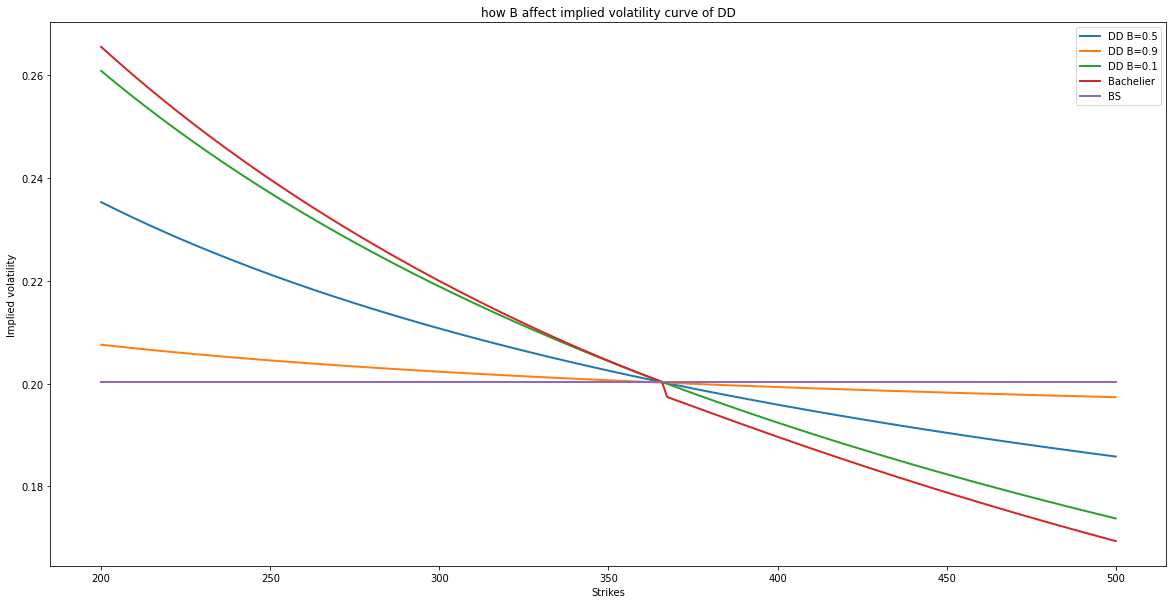

In [154]:
plt.figure(figsize = (20,10))

df = pd.DataFrame(summary, columns=['strike', 'vol'])
df_high = pd.DataFrame(summary_high, columns=['strike', 'vol'])
df_low = pd.DataFrame(summary_low, columns=['strike', 'vol'])

df_bs= pd.DataFrame(summaryBS, columns=['strike', 'vol'])

df_n= pd.DataFrame(summaryN, columns=['strike', 'vol'])

df.set_index('strike', drop=True, inplace=True)
plt.plot(df['vol'], linewidth=2.0, label='DD B=0.5')

df_high.set_index('strike', drop=True, inplace=True)
plt.plot(df_high['vol'], linewidth=2.0, label='DD B=0.9')

df_low.set_index('strike', drop=True, inplace=True)
plt.plot(df_low['vol'], linewidth=2.0, label='DD B=0.1')

df_n.set_index('strike', drop=True, inplace=True)
plt.plot(df_n['vol'], linewidth=2.0, label='Bachelier')

df_bs.set_index('strike', drop=True, inplace=True)
plt.plot(df_bs['vol'], linewidth=2.0, label='BS')
#plt.axis([0, 170, -0.1, 2.0])


#plt.axis([190, 520, -0.1, 0.4])
plt.legend()
plt.xlabel('Strikes')
plt.ylabel('Implied volatility')
plt.title("how B affect implied volatility curve of DD")
plt.show()

## How does change in rho and nu in SABR model affect the shape of the implied volatility

In [108]:
#using SABR model fitted to volatility smile of 20210115 expiry option data of SPX as baseline but change rho as 0 (for better illustration)
sabrvols_jan_spx = []
for K in strikes_jan_spx:
    sabrvols_jan_spx.append(SABR(df_spx_jan["F"].iloc[0], K, df_spx_jan["T"].iloc[0], 
                             tuned_params_jan_spx[0], tuned_params_jan_spx[1], 0 , tuned_params_jan_spx[3]))

In [109]:
#basline rho
tuned_params_jan_spx[2]

-0.4043017684474367

In [110]:
#higher and lower rho
higher_rho =  0.4
lower_rho =  - 0.4

In [111]:
#basline nu
tuned_params_jan_spx[3]

2.7901583144132664

In [112]:
#higher and lower nu
higher_nu = tuned_params_jan_spx[3] +2
lower_nu = tuned_params_jan_spx[3] - 2

In [113]:
## get implied vol using model with different value of rho and nu

sabrvols_jan_high_rho = []
for K in strikes_jan_spx:
    sabrvols_jan_high_rho.append(SABR(df_spx_jan["F"].iloc[0], K, df_spx_jan["T"].iloc[0], 
                             tuned_params_jan_spx[0], tuned_params_jan_spx[1], higher_rho, tuned_params_jan_spx[3]))
    
sabrvols_jan_low_rho = []
for K in strikes_jan_spx:
    sabrvols_jan_low_rho.append(SABR(df_spx_jan["F"].iloc[0], K, df_spx_jan["T"].iloc[0], 
                             tuned_params_jan_spx[0], tuned_params_jan_spx[1], lower_rho, tuned_params_jan_spx[3]))
    
sabrvols_jan_high_nu = []
for K in strikes_jan_spx:
    sabrvols_jan_high_nu.append(SABR(df_spx_jan["F"].iloc[0], K, df_spx_jan["T"].iloc[0], 
                             tuned_params_jan_spx[0], tuned_params_jan_spx[1], tuned_params_jan_spx[2], higher_nu))
    
sabrvols_jan_low_nu = []
for K in strikes_jan_spx:
    sabrvols_jan_low_nu.append(SABR(df_spx_jan["F"].iloc[0], K, df_spx_jan["T"].iloc[0], 
                             tuned_params_jan_spx[0], tuned_params_jan_spx[1], tuned_params_jan_spx[2],lower_nu))

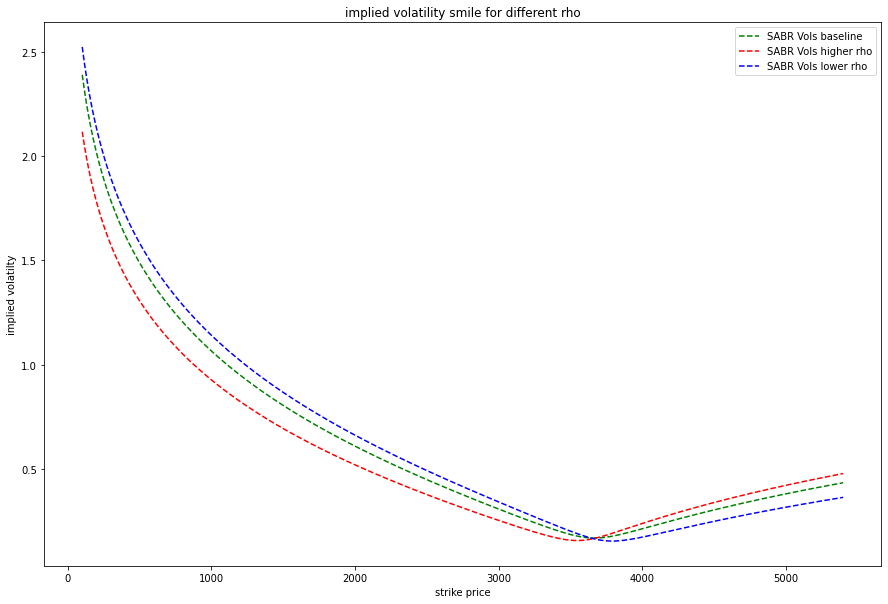

In [114]:
plt.figure(figsize = (15,10))


plt.plot(strikes_jan_spx, sabrvols_jan_spx, 'g--', label= f'SABR Vols baseline')
plt.plot(strikes_jan_spx, sabrvols_jan_high_rho, 'r--', label= f'SABR Vols higher rho')
plt.plot(strikes_jan_spx, sabrvols_jan_low_rho, 'b--', label= f'SABR Vols lower rho')



plt.legend()
plt.title(f"implied volatility smile for different rho")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()

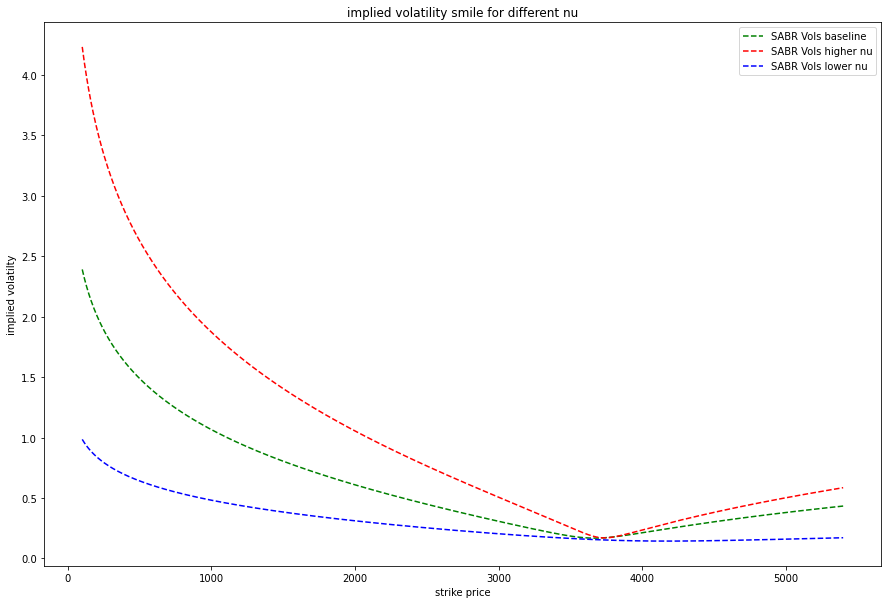

In [115]:
plt.figure(figsize = (15,10))


plt.plot(strikes_jan_spx, sabrvols_jan_spx, 'g--', label= f'SABR Vols baseline')
plt.plot(strikes_jan_spx, sabrvols_jan_high_nu, 'r--', label= f'SABR Vols higher nu')
plt.plot(strikes_jan_spx, sabrvols_jan_low_nu, 'b--', label= f'SABR Vols lower nu')



plt.legend()
plt.title(f"implied volatility smile for different nu")
plt.xlabel("strike price")
plt.ylabel("implied volatilty")
plt.show()